In [9]:
!git clone https://github.com/iskandr/fancyimpute.git

Cloning into 'fancyimpute'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1055 (delta 3), reused 0 (delta 0), pack-reused 1041
Receiving objects: 100% (1055/1055), 269.14 KiB | 13.46 MiB/s, done.
Resolving deltas: 100% (711/711), done.


# Functions


In [10]:
%cd /content/fancyimpute/test/

/content/fancyimpute/test


In [11]:
from low_rank_data import XY, XY_incomplete, missing_mask
from common import reconstruction_error

In [12]:
%cd /content/fancyimpute/fancyimpute/

/content/fancyimpute/fancyimpute


In [13]:
!apt-get install python3-nose

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-nose is already the newest version (1.3.7-3).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [14]:
import pandas as pd
import os
import numpy as np
import warnings
import logging
import importlib
from sklearn.utils import check_array
from nose.tools import eq_

from fancyimpute.knn import KNN


from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Input
from keras.models import Model
from sklearn.utils import shuffle, check_array

from scaler import Scaler
from keras_models import KerasMatrixFactorizer


#import required packages
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def import_from(module, name):
    '''
    usage example:
    grid = import_from('sklearn.model_selection', 'GridSearchCV')
    is equivalent to:
    from sklearn.model_selection import GridSearchV as grid
    '''
    module = importlib.import_module(module)
    return getattr(module, name)

In [16]:
def generate_random_column_samples(column):
    col_mask = np.isnan(column)
    n_missing = np.sum(col_mask)
    if n_missing == len(column):
        logging.warn("No observed values in column")
        return np.zeros_like(column)

    mean = np.nanmean(column)
    std = np.nanstd(column)

    if np.isclose(std, 0):
        return np.array([mean] * n_missing)
    else:
        return np.random.randn(n_missing) * std + mean


In [17]:
class Solver(object):
    def __init__(
            self,
            fill_method="zero",
            min_value=None,
            max_value=None,
            normalizer=None):
        self.fill_method = fill_method
        self.min_value = min_value
        self.max_value = max_value
        self.normalizer = normalizer

    def __repr__(self):
        return str(self)

    def __str__(self):
        field_list = []
        for (k, v) in sorted(self.__dict__.items()):
            if v is None or isinstance(v, (float, int)):
                field_list.append("%s=%s" % (k, v))
            elif isinstance(v, str):
                field_list.append("%s='%s'" % (k, v))
        return "%s(%s)" % (
            self.__class__.__name__,
            ", ".join(field_list))

    def _check_input(self, X):
        if len(X.shape) != 2:
            raise ValueError("Expected 2d matrix, got %s array" % (X.shape,))

    def _check_missing_value_mask(self, missing):
        if not missing.any():
            warnings.simplefilter("always")
            warnings.warn("Input matrix is not missing any values")
        if missing.all():
            raise ValueError("Input matrix must have some non-missing values")

    def _fill_columns_with_fn(self, X, missing_mask, col_fn):
        for col_idx in range(X.shape[1]):
            missing_col = missing_mask[:, col_idx]
            n_missing = missing_col.sum()
            if n_missing == 0:
                continue
            col_data = X[:, col_idx]
            fill_values = col_fn(col_data)
            if np.all(np.isnan(fill_values)):
                fill_values = 0
            X[missing_col, col_idx] = fill_values

    def fill(
            self,
            X,
            missing_mask,
            fill_method=None,
            inplace=False):
        """
        Parameters
        ----------
        X : np.array
            Data array containing NaN entries

        missing_mask : np.array
            Boolean array indicating where NaN entries are

        fill_method : str
            "zero": fill missing entries with zeros
            "mean": fill with column means
            "median" : fill with column medians
            "min": fill with min value per column
            "random": fill with gaussian samples according to mean/std of column

        inplace : bool
            Modify matrix or fill a copy
        """
        X = check_array(X, force_all_finite=False)

        if not inplace:
            X = X.copy()

        if not fill_method:
            fill_method = self.fill_method

        if fill_method not in ("zero", "mean", "median", "min", "random"):
            raise ValueError("Invalid fill method: '%s'" % (fill_method))
        elif fill_method == "zero":
            # replace NaN's with 0
            X[missing_mask] = 0
        elif fill_method == "mean":
            self._fill_columns_with_fn(X, missing_mask, np.nanmean)
        elif fill_method == "median":
            self._fill_columns_with_fn(X, missing_mask, np.nanmedian)
        elif fill_method == "min":
            self._fill_columns_with_fn(X, missing_mask, np.nanmin)
        elif fill_method == "random":
            self._fill_columns_with_fn(
                X,
                missing_mask,
                col_fn=generate_random_column_samples)
        return X

    def prepare_input_data(self, X):
        """
        Check to make sure that the input matrix and its mask of missing
        values are valid. Returns X and missing mask.
        """
        X = check_array(X, force_all_finite=False)
        if X.dtype != "f" and X.dtype != "d":
            X = X.astype(float)

        self._check_input(X)
        missing_mask = np.isnan(X)
        self._check_missing_value_mask(missing_mask)
        return X, missing_mask

    def clip(self, X):
        """
        Clip values to fall within any global or column-wise min/max constraints
        """
        X = np.asarray(X)
        if self.min_value is not None:
            X[X < self.min_value] = self.min_value
        if self.max_value is not None:
            X[X > self.max_value] = self.max_value
        return X

    def project_result(self, X):
        """
        First undo normalization and then clip to the user-specified min/max
        range.
        """
        X = np.asarray(X)
        if self.normalizer is not None:
            X = self.normalizer.inverse_transform(X)
        return self.clip(X)

    def solve(self, X, missing_mask):
        """
        Given an initialized matrix X and a mask of where its missing values
        had been, return a completion of X.
        """
        raise ValueError("%s.solve not yet implemented!" % (
            self.__class__.__name__,))

    def fit_transform(self, X, y=None):
        """
        Fit the imputer and then transform input `X`

        Note: all imputations should have a `fit_transform` method,
        but only some (like IterativeImputer in sklearn) also support inductive
        mode using `fit` or `fit_transform` on `X_train` and then `transform`
        on new `X_test`.
        """
        X_original, missing_mask = self.prepare_input_data(X)
        observed_mask = ~missing_mask
        X = X_original.copy()
        if self.normalizer is not None:
            X = self.normalizer.fit_transform(X)
        X_filled = self.fill(X, missing_mask, inplace=True)
        if not isinstance(X_filled, np.ndarray):
            raise TypeError(
                "Expected %s.fill() to return NumPy array but got %s" % (
                    self.__class__.__name__,
                    type(X_filled)))

        X_result = self.solve(X_filled, missing_mask)
        if not isinstance(X_result, np.ndarray):
            raise TypeError(
                "Expected %s.solve() to return NumPy array but got %s" % (
                    self.__class__.__name__,
                    type(X_result)))

        X_result = self.project_result(X=X_result)
        X_result[observed_mask] = X_original[observed_mask]
        return X_result

    def fit(self, X, y=None):
        """
        Fit the imputer on input `X`.

        Note: all imputations should have a `fit_transform` method,
        but only some (like IterativeImputer in sklearn) also support inductive
        mode using `fit` or `fit_transform` on `X_train` and then `transform`
        on new `X_test`.
        """
        raise ValueError(
            "%s.fit not implemented! This imputation algorithm likely "
            "doesn't support inductive mode. Only fit_transform is "
            "supported at this time." % (
                self.__class__.__name__,))

    def transform(self, X, y=None):
        """
        Transform input `X`.

        Note: all imputations should have a `fit_transform` method,
        but only some (like IterativeImputer in sklearn) also support inductive
        mode using `fit` or `fit_transform` on `X_train` and then `transform`
        on new `X_test`.
        """
        raise ValueError(
            "%s.transform not implemented! This imputation algorithm likely "
            "doesn't support inductive mode. Only %s.fit_transform is "
            "supported at this time." % (
                self.__class__.__name__, self.__class__.__name__))


In [18]:
class MatrixFactorization(Solver):
    """
    Given an incomplete (m,n) matrix X, factorize it into
    U, V where U.shape = (m, k) and V.shape = (k, n).

    The U, V are found by minimizing the difference between U.dot.V and
    X at the observed entries along with a sparsity penalty for U and an
    L2 penalty for V.
    """

    def __init__(
            self,
            rank=10,
            learning_rate=0.001,
            epochs=10000,
            patience=5,
            l2_penalty=1e-5,
            use_bias=True,
            min_improvement=0.001,
            optimization_algorithm="Adam",
            loss='mse',
            validation_frac=0.1,
            min_value=None,
            max_value=None,
            normalizer=Scaler(),
            verbose=True):
        Solver.__init__(
            self,
            min_value=min_value,
            max_value=max_value,
            normalizer=normalizer)
        self.rank = rank
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience = patience
        self.l2_penalty = l2_penalty
        self.use_bias = use_bias
        self.optimization_algorithm = optimization_algorithm
        self.loss = loss
        self.validation_frac = validation_frac
        self.min_improvement = min_improvement
        self.normalizer = normalizer
        self.verbose = verbose

    def solve(self, X, missing_mask):
        X = check_array(X, force_all_finite=False)

        # shape data to fit into keras model
        (n_samples, n_features) = X.shape
        observed_mask = ~missing_mask
        missing_mask_flat = missing_mask.flatten()
        observed_mask_flat = observed_mask.flatten()

        columns, rows = np.meshgrid(np.arange(n_features), np.arange(n_samples))

        # training data
        i_tr = rows.flatten()[observed_mask_flat]
        j_tr = columns.flatten()[observed_mask_flat]
        ij_tr = np.vstack([i_tr, j_tr]).T  # input to factorizer
        y_tr = X.flatten()[observed_mask_flat]  # output of factorizer
        ij_tr, y_tr = shuffle(ij_tr, y_tr)

        # make a keras model
        main_input = Input(shape=(2,), dtype='int32')
        embed = KerasMatrixFactorizer(
            rank=self.rank,
            input_dim_i=n_samples,
            input_dim_j=n_features,
            embeddings_regularizer=regularizers.l2(self.l2_penalty),
            use_bias=self.use_bias
        )(main_input)
        model = Model(inputs=main_input, outputs=embed)
        optimizer = import_from(
            'keras.optimizers', self.optimization_algorithm
        )(lr=self.learning_rate)
        model.compile(optimizer=optimizer, loss=self.loss)
        callbacks = [EarlyStopping(patience=self.patience, min_delta=self.min_improvement)]
        model.fit(
            ij_tr,
            y_tr,
            batch_size=int(len(y_tr) * (1 - self.validation_frac)),
            epochs=self.epochs,
            validation_split=self.validation_frac,
            callbacks=callbacks,
            shuffle=True,
            verbose=self.verbose
        )

        # reassemble the original X
        i_ts = rows.flatten()[missing_mask_flat]
        j_ts = columns.flatten()[missing_mask_flat]
        ij_ts = np.vstack([i_ts, j_ts]).T  # input to factorizer
        X[i_ts, j_ts] = model.predict(ij_ts).T[0]

        return X

# Performance Model

In [ ]:
def test_matrix_factorization_with_low_rank_random_matrix():
    solver = MatrixFactorization(
        learning_rate=0.01,
        rank=3,
        l2_penalty=0,
        min_improvement=1e-6)
    #print(solver)
    XY_completed = solver.fit_transform(XY_incomplete)
    #print(XY_completed)
    _, missing_mae = reconstruction_error(
        XY,
        XY_completed,
        missing_mask,
        name="MatrixFactorization")
    assert missing_mae < 0.1, "Error too high!"
    return XY_completed, solver 


In [ ]:
X_filled = test_matrix_factorization_with_low_rank_random_matrix()

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 2612/10000
1/1 [==============================] - 0s 79ms/step - loss: 4.5226e-05 - val_loss: 0.0558
Epoch 2613/10000
1/1 [==============================] - 0s 79ms/step - loss: 4.5263e-05 - val_loss: 0.0557
Epoch 2614/10000
1/1 [==============================] - 0s 82ms/step - loss: 4.5319e-05 - val_loss: 0.0558
Epoch 2615/10000
1/1 [==============================] - 0s 91ms/step - loss: 4.5323e-05 - val_loss: 0.0557
Epoch 2616/10000
1/1 [==============================] - 0s 78ms/step - loss: 4.5345e-05 - val_loss: 0.0558
Epoch 2617/10000
1/1 [==============================] - 0s 80ms/step - loss: 4.5316e-05 - val_loss: 0.0557
Epoch 2618/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.5306e-05 - val_loss: 0.0558
Epoch 2619/10000
1/1 [==============================] - 0s 77ms/step - loss: 4.5243e-05 - val_loss: 0.0557
Epoch 2620/10000
1/1 [==============================] - 0s 81ms/step - loss: 4.520

# Iterative Super Vector Machine

In [ ]:
from fancyimpute import IterativeSVD

def test_iterative_svd_with_low_rank_random_matrix():
    solver = IterativeSVD(rank=3)
    XY_completed = solver.fit_transform(XY_incomplete)
    _, missing_mae = reconstruction_error(
        XY,
        XY_completed,
        missing_mask,
        name="IterativeSVD")
    assert missing_mae < 0.1, "Error too high!"


X_filled_svd = test_iterative_svd_with_low_rank_random_matrix()

[IterativeSVD] Iter 1: observed MAE=0.729475
[IterativeSVD] Iter 2: observed MAE=0.414636
[IterativeSVD] Iter 3: observed MAE=0.135410
[IterativeSVD] Iter 4: observed MAE=0.078199
[IterativeSVD] Iter 5: observed MAE=0.052945
[IterativeSVD] Iter 6: observed MAE=0.039155
[IterativeSVD] Iter 7: observed MAE=0.030250
[IterativeSVD] Iter 8: observed MAE=0.024050
[IterativeSVD] Iter 9: observed MAE=0.019528
[IterativeSVD] Iter 10: observed MAE=0.016155
[IterativeSVD] Iter 11: observed MAE=0.013570
[IterativeSVD] Iter 12: observed MAE=0.011550
[IterativeSVD] Iter 13: observed MAE=0.009947
[IterativeSVD] Iter 14: observed MAE=0.008645
[IterativeSVD] Iter 15: observed MAE=0.007572
[IterativeSVD] Iter 16: observed MAE=0.006677
[IterativeSVD] Iter 17: observed MAE=0.005925
[IterativeSVD] Iter 18: observed MAE=0.005290
[IterativeSVD] Iter 19: observed MAE=0.004748
[IterativeSVD] Iter 20: observed MAE=0.004283
[IterativeSVD] Iter 21: observed MAE=0.003884
[IterativeSVD] Iter 22: observed MAE=0.0035

In [ ]:
def test_knn():
    # get a baseline error from just zero-filling the missing entries
    sad_zero_fill = np.sum(np.abs(XY[missing_mask]))
    mad_zero_fill = sad_zero_fill / missing_mask.sum()
    print("MAD zero-fill = ", mad_zero_fill)
    for k in [5, 15, 30]:
        print("-- k=", k)
        XY_completed = KNN(k).fit_transform(XY_incomplete)
        mask = np.isfinite(XY_completed)
        eq_((~mask).sum(), 0)
        diff = (XY_completed - XY)[missing_mask]
        sad = np.sum(np.abs(diff))
        mad = sad / missing_mask.sum()
        print("Mean absolute error", mad)
        # knnImpute should be at least twice as good as just zero fill
        assert mad <= (mad_zero_fill / 2.0), \
            "Expected knnImpute to be 2x better than zeroFill (%f) but got MAD=%f" % (
                mad_zero_fill,
                mad)

In [ ]:
X_filled_knn = test_knn()

MAD zero-fill =  1.1593901478619075
-- k= 5
Imputing row 1/500 with 4 missing, elapsed time: 0.063
Imputing row 101/500 with 4 missing, elapsed time: 0.070
Imputing row 201/500 with 4 missing, elapsed time: 0.078
Imputing row 301/500 with 3 missing, elapsed time: 0.085
Imputing row 401/500 with 4 missing, elapsed time: 0.093
Mean absolute error 0.5122055775761624
-- k= 15
Imputing row 1/500 with 4 missing, elapsed time: 0.053
Imputing row 101/500 with 4 missing, elapsed time: 0.059
Imputing row 201/500 with 4 missing, elapsed time: 0.065
Imputing row 301/500 with 3 missing, elapsed time: 0.069
Imputing row 401/500 with 4 missing, elapsed time: 0.077
Mean absolute error 0.4832376639047212
-- k= 30
Imputing row 1/500 with 4 missing, elapsed time: 0.058
Imputing row 101/500 with 4 missing, elapsed time: 0.065
Imputing row 201/500 with 4 missing, elapsed time: 0.073
Imputing row 301/500 with 3 missing, elapsed time: 0.081
Imputing row 401/500 with 4 missing, elapsed time: 0.089
Mean absolu

# Handling NAN values in quality air sensors

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = '/content/drive/MyDrive/IMT Atlantique/Project_S5_Air/Data_csv/DataIlias/'
# pathdir  = np.array(os.listdir(path))
# csv_file_list = {}


# for dirname in pathdir:
#   csv_file_list[dirname] = pd.read_csv(path + dirname, header=0, index_col=0).reset_index()



In [ ]:
# super_df = pd.concat(csv_file_list.values(), keys=csv_file_list.keys())
# super_df.reset_index(inplace=True)
# super_df.rename(columns={'level_0': 'Sensor'}, inplace=True)
# super_df

,Sensor,level_1,Date,Hour,PM2_MIN,PM2_MAX,PM2_MOY
0,sensor16v2.csv,0,2019-08-28,0,400,400,400
1,sensor16v2.csv,1,2019-08-28,1,400,400,400
2,sensor16v2.csv,2,2019-08-28,2,400,400,400
3,sensor16v2.csv,3,2019-08-28,3,400,400,400
4,sensor16v2.csv,4,2019-08-28,4,400,400,400
...,...,...,...,...,...,...,...
63979,sensor59v2.csv,1483,2019-10-28,19,400,400,400
63980,sensor59v2.csv,1484,2019-10-28,20,400,400,400
63981,sensor59v2.csv,1485,2019-10-28,21,400,400,400
63982,sensor59v2.csv,1486,2019-10-28,22,400,400,400


In [ ]:
# super_df.drop(columns=['level_1'], inplace=True)

In [ ]:
# super_df[super_df[['PM2_MIN', 'PM2_MAX', 'PM2_MOY']] == 400] = np.nan

In [ ]:
# super_df.to_csv('/content/drive/MyDrive/IMT Atlantique/Project_S5_Air/Data_csv/superdfi.csv')

In [19]:
super_df = pd.read_csv('/content/drive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor/data/superdfi.csv', header=0, index_col=0)

In [ ]:
filldf = super_df.copy(deep=True)
filldf.drop(columns=['Sensor','Date', 'Hour'], inplace=True)

In [ ]:
X_incomplete = filldf.to_numpy()

In [ ]:
solverSensors = MatrixFactorization(
        learning_rate=0.01,
        rank=3,
        l2_penalty=0,
        min_improvement=1e-6)

In [ ]:
X_completed = solverSensors.fit_transform(X_incomplete)

Epoch 1/10000
1/1 [==============================] - 1s 973ms/step - loss: 1.4647 - val_loss: 1.4492
Epoch 2/10000
1/1 [==============================] - 0s 70ms/step - loss: 1.4154 - val_loss: 1.4244
Epoch 3/10000
1/1 [==============================] - 0s 72ms/step - loss: 1.3805 - val_loss: 1.4027
Epoch 4/10000
1/1 [==============================] - 0s 184ms/step - loss: 1.3497 - val_loss: 1.3819
Epoch 5/10000
1/1 [==============================] - 0s 74ms/step - loss: 1.3202 - val_loss: 1.3613
Epoch 6/10000
1/1 [==============================] - 0s 72ms/step - loss: 1.2914 - val_loss: 1.3409
Epoch 7/10000
1/1 [==============================] - 0s 70ms/step - loss: 1.2630 - val_loss: 1.3205
Epoch 8/10000
1/1 [==============================] - 0s 69ms/step - loss: 1.2351 - val_loss: 1.3003
Epoch 9/10000
1/1 [==============================] - 0s 69ms/step - loss: 1.2077 - val_loss: 1.2801
Epoch 10/10000
1/1 [==============================] - 0s 68ms/step - loss: 1.1808 - val_loss: 1.26

In [ ]:
print(X_incomplete)
print(X_completed)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 ...
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[ 17.3611462   24.65436082  20.8906025 ]
 [ 23.72402051  44.14660158  32.58474362]
 [  6.3346886   10.49705616   7.84149126]
 ...
 [ 70.53606146 110.91280718  90.34005848]
 [ 39.91364232  61.45073436  50.38389253]
 [ 57.94142652  86.44004997  72.38476085]]


In [ ]:
super_dfFilled = pd.DataFrame(X_completed, columns = ['PM2_MIN','PM2_MAX','PM2_MOY'])

In [ ]:
super_df.head()

,Sensor,Date,Hour,PM2_MIN,PM2_MAX,PM2_MOY
0,sensor16v2.csv,2019-08-28,0,NaN,NaN,NaN
1,sensor16v2.csv,2019-08-28,1,NaN,NaN,NaN
2,sensor16v2.csv,2019-08-28,2,NaN,NaN,NaN
3,sensor16v2.csv,2019-08-28,3,NaN,NaN,NaN
4,sensor16v2.csv,2019-08-28,4,NaN,NaN,NaN


In [ ]:
super_dfFilled[['Sensor', 'Date', 'Hour']] = super_df[['Sensor', 'Date', 'Hour']]

In [ ]:
super_dfFilled = super_dfFilled[['Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX', 'PM2_MOY']]
super_dfFilled

,Sensor,Date,Hour,PM2_MIN,PM2_MAX,PM2_MOY
0,sensor16v2.csv,2019-08-28,0,17.361146,24.654361,20.890603
1,sensor16v2.csv,2019-08-28,1,23.724021,44.146602,32.584744
2,sensor16v2.csv,2019-08-28,2,6.334689,10.497056,7.841491
3,sensor16v2.csv,2019-08-28,3,80.047917,126.959842,103.029719
4,sensor16v2.csv,2019-08-28,4,56.158266,82.691930,69.724671
...,...,...,...,...,...,...
63979,sensor59v2.csv,2019-10-28,19,54.898410,89.304924,71.321650
63980,sensor59v2.csv,2019-10-28,20,46.331950,76.160910,60.428250
63981,sensor59v2.csv,2019-10-28,21,70.536061,110.912807,90.340058
63982,sensor59v2.csv,2019-10-28,22,39.913642,61.450734,50.383893


In [ ]:
super_dfFilled.isnull().sum().sum(  )

0

# Performance in interval of time series without NAN values

In [ ]:
super_df.head()

,Sensor,Date,Hour,PM2_MIN,PM2_MAX,PM2_MOY
0,sensor16v2.csv,2019-08-28,0,NaN,NaN,NaN
1,sensor16v2.csv,2019-08-28,1,NaN,NaN,NaN
2,sensor16v2.csv,2019-08-28,2,NaN,NaN,NaN
3,sensor16v2.csv,2019-08-28,3,NaN,NaN,NaN
4,sensor16v2.csv,2019-08-28,4,NaN,NaN,NaN


In [ ]:
aux = super_df[(super_df['Sensor'] == 'sensor14v2.csv') | (super_df['Sensor'] == 'sensor13v2.csv') | (super_df['Sensor'] == 'sensor12v2.csv')]
aux =aux.dropna().reset_index()
#aux.isnull().sum().sum()


In [ ]:
#nn = aux.drop(columns=['index', 'Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX'])
nn = aux.drop(columns=['index', 'Sensor', 'Date', 'Hour'])
nn

,PM2_MIN,PM2_MAX,PM2_MOY
0,8.0,9.0,8.0
1,8.0,9.0,8.0
2,8.0,9.0,8.0
3,8.0,9.0,8.0
4,8.0,9.0,8.0
...,...,...,...
3813,4.0,12.0,8.0
3814,4.0,12.0,8.0
3815,4.0,12.0,8.0
3816,4.0,16.0,10.0


In [ ]:
n_rows=500  
n_cols=10
k=3

x = np.random.randn(n_rows, k)
y = np.random.randn(k, n_cols)

XY = np.dot(x, y)

missing_raw_values = np.random.uniform(0, 1, (n_rows, n_cols))
missing_mask = missing_raw_values < 0.25

XY_incompletee = XY.copy()
# fill missing entries with NaN
XY_incompletee[missing_mask] = np.nan


In [ ]:
aux_arr = nn.to_numpy()
aux_incomplete =  np.copy(aux_arr)
missing_raw_values = np.random.uniform(0, 1, aux_arr.shape)
missing_mask = missing_raw_values < 0.25
aux_incomplete[missing_mask] = np.nan


In [ ]:
np.isnan(aux_incomplete).sum()

2906

In [ ]:
#np.array_equal(aux_arr,nn.to_numpy()) 
# print(aux_incomplete[missing_mask])

True

In [ ]:
# Define our candidate hyperparameters
hp_candidates = [{'rank' : [1, 2, 3], 'learning_rate' : [0.001, 0.0001, 0.01, 0.00001],
                  'l2_penalty' : [1e-5, 1e-6, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1], 'patience' : [400, 600, 800],
                  'validation_frac' : [0.1, 0.15, 0.2], 'min_improvement' : [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-10],
                  'l2_penalty' : [0, 1e-5, 1e-4, 1e-3, 1e-6, 1e-9]}]

In [ ]:
def test_matrix_completion():
    solverTestSensors = MatrixFactorization(
        learning_rate=0.001,
        rank=2,
        l2_penalty= 1e-5,
        patience=100,
        validation_frac=0.15,
        min_improvement=1e-6)
    aux_completed = solverTestSensors.fit_transform(aux_incomplete)
    #print(XY_completed)
    _, missing_mae = reconstruction_error(
        aux_arr,
        aux_completed,   
        missing_mask,
        name="MatrixFactorization")
    #assert missing_mae < 0.1, "Error too high!"
    return aux_completed 
aux_completed = test_matrix_completion()

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 4324/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0065 - val_loss: 0.2483
Epoch 4325/10000
1/1 [==============================] - 0s 92ms/step - loss: 0.0065 - val_loss: 0.2482
Epoch 4326/10000
1/1 [==============================] - 0s 92ms/step - loss: 0.0065 - val_loss: 0.2482
Epoch 4327/10000
1/1 [==============================] - 0s 89ms/step - loss: 0.0065 - val_loss: 0.2481
Epoch 4328/10000
1/1 [==============================] - 0s 93ms/step - loss: 0.0065 - val_loss: 0.2480
Epoch 4329/10000
1/1 [==============================] - 0s 215ms/step - loss: 0.0065 - val_loss: 0.2480
Epoch 4330/10000
1/1 [==============================] - 0s 84ms/step - loss: 0.0065 - val_loss: 0.2479
Epoch 4331/10000
1/1 [==============================] - 0s 104ms/step - loss: 0.0065 - val_loss: 0.2479
Epoch 4332/10000
1/1 [==============================] - 0s 92ms/step - loss: 0.0065 - val_loss: 0.2478
Epoch 433

In [ ]:
from fancyimpute import IterativeSVD

def test_iterative_svd_with_low_rank_random_matrix():
    solver = IterativeSVD(rank=1, convergence_threshold=0.00000001)
    aux_completed = solver.fit_transform(aux_incomplete)
    _, missing_mae = reconstruction_error(
        aux_arr,
        aux_completed,
        missing_mask,
        name="IterativeSVD")
    #assert missing_mae < 1.2, "Error too high!"
    return aux_completed


aux_completed2 = test_iterative_svd_with_low_rank_random_matrix()

[IterativeSVD] Iter 1: observed MAE=1.864427
[IterativeSVD] Iter 2: observed MAE=1.134494
[IterativeSVD] Iter 3: observed MAE=0.901803
[IterativeSVD] Iter 4: observed MAE=0.815833
[IterativeSVD] Iter 5: observed MAE=0.773286
[IterativeSVD] Iter 6: observed MAE=0.747059
[IterativeSVD] Iter 7: observed MAE=0.729932
[IterativeSVD] Iter 8: observed MAE=0.718215
[IterativeSVD] Iter 9: observed MAE=0.709952
[IterativeSVD] Iter 10: observed MAE=0.704215
[IterativeSVD] Iter 11: observed MAE=0.700120
[IterativeSVD] Iter 12: observed MAE=0.696984
[IterativeSVD] Iter 13: observed MAE=0.694594
[IterativeSVD] Iter 14: observed MAE=0.692779
[IterativeSVD] Iter 15: observed MAE=0.691384
[IterativeSVD] Iter 16: observed MAE=0.690311
[IterativeSVD] Iter 17: observed MAE=0.689481
[IterativeSVD] Iter 18: observed MAE=0.688848
[IterativeSVD] Iter 19: observed MAE=0.688357
[IterativeSVD] Iter 20: observed MAE=0.687974
[IterativeSVD] Iter 21: observed MAE=0.687676
[IterativeSVD] Iter 22: observed MAE=0.6874

In [ ]:
aux_completed2 = pd.DataFrame(aux_completed2, columns = ['PM2_MIN','PM2_MAX','PM2_MOY'])
aux_completed2[['Sensor', 'Date', 'Hour']] = aux[['Sensor', 'Date', 'Hour']]
aux_completed2 = aux_completed2[['Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX', 'PM2_MOY']]
aux_completed2['Date'] = pd.to_datetime(aux_completed2['Date'])
aux = aux.sort_values(by='Date')

NameError: ignored

Text(0, 0.5, 'PM2 Moyenne')

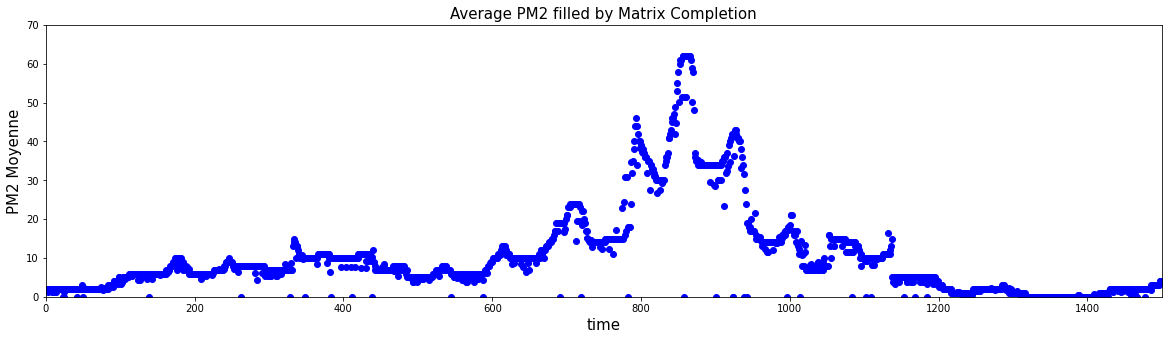

In [ ]:
plt.figure(figsize=(20,5))
plt.axis([0,1500, 0, 70])
plt.plot(aux_completed['PM2_MIN'],'bo')
plt.title('Average PM2 filled by Matrix Completion', size=15)
plt.xlabel('time',size=15)
plt.ylabel('PM2 Moyenne',size=15)




Text(0, 0.5, 'PM2 Moyenne')

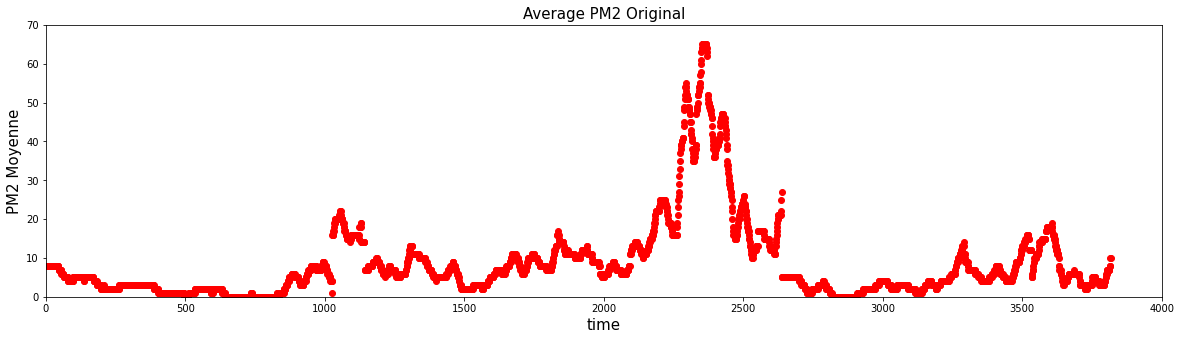

In [ ]:
plt.figure(figsize=(20,5))
plt.axis([0,4000, 0, 70])
plt.plot(aux['PM2_MOY'], 'ro')
plt.title('Average PM2 Original', size=15)
plt.xlabel('time', size=15)
plt.ylabel('PM2 Moyenne', size=15)

In [ ]:
aux['Date'] = pd.to_datetime(aux['Date'])

In [ ]:
aux['PM2_MOY'].max()

136.0

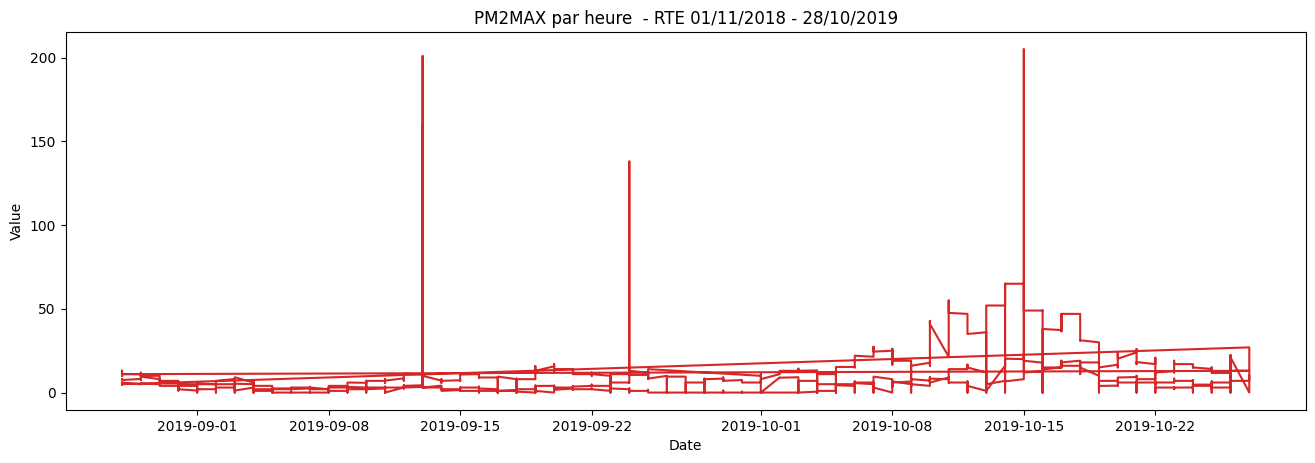

In [ ]:
# Affichage
def plot_df(df, x, y, title="qu'est-ce ?", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(aux_completed2, x=aux_completed2['Date'], y=aux_completed2['PM2_MOY'],title='PM2MAX par heure  - RTE 01/11/2018 - 28/10/2019')


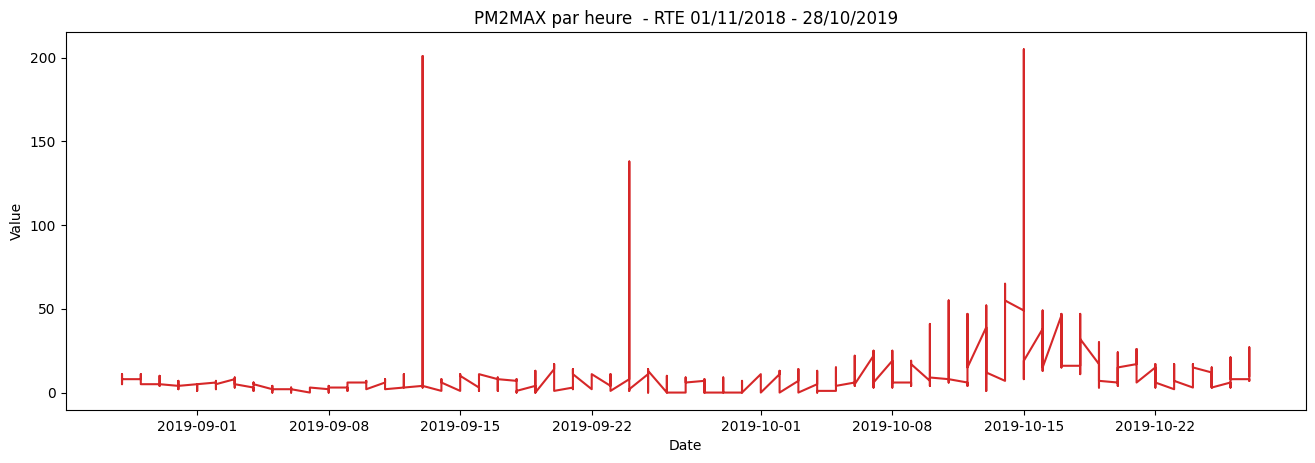

In [ ]:
plot_df(aux, x=aux['Date'], y=aux['PM2_MOY'],title='PM2MAX par heure  - RTE 01/11/2018 - 28/10/2019')

In [ ]:
from fancyimpute import (NuclearNormMinimization)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
def test_nuclear_norm_minimization_with_low_rank_random_matrix():
    solver = NuclearNormMinimization(max_iters=2000)
    XY_completed = solver.fit_transform(aux_incomplete[0:4000])
    _, missing_mae = reconstruction_error(
        aux_arr[0:4000], XY_completed, missing_mask[0:4000], name="NuclearNorm")
    #assert missing_mae < 0.1, "Error too high!"
    return XY_completed

In [ ]:
 aux_completed = test_nuclear_norm_minimization_with_low_rank_random_matrix()

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7376191
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 7324839, constraints m = 7347747
Cones:	primal zero / dual free vars: 11454
	linear vars: 34362
	sd vars: 7301931, sd blks: 1
Setup time: 9.10e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------


In [ ]:
aux_completed = pd.DataFrame(aux_completed, columns = ['PM2_MIN','PM2_MAX','PM2_MOY'])
aux_completed[['Sensor', 'Date', 'Hour']] = aux[['Sensor', 'Date', 'Hour']]
aux_completed = aux_completed[['Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX', 'PM2_MOY']]
aux_completed['Date'] = pd.to_datetime(aux_completed['Date'])
aux['Date'] = pd.to_datetime(aux['Date'])

In [21]:
super_df['PM2_MOY'].describe()

count    55474.000000
mean        14.333201
std         23.093834
min          0.000000
25%          3.000000
50%          7.000000
75%         15.000000
max        315.000000
Name: PM2_MOY, dtype: float64

In [22]:
super_df['PM2_MOY'].isnull().sum().sum()

8510

In [23]:
(8510 * 100 ) / 55474

15.34051988318852